In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [497]:
# ============================
# 1. Chargement des données
# ============================

annee = 2022
def chargement_et_preparation_donnees_annee(annee):
    df = pd.read_csv(r'C:\Users\selim\Desktop\Data_total\All_tweets.csv')
    df = df.drop_duplicates(subset="id")
    df['query_date'] = pd.to_datetime(df['query_date'])
    df['year'] = df['query_date'].dt.year
    df['month'] = df['query_date'].dt.month
    df = df.sort_values(by='query_date').reset_index(drop=True)
    df = df[df['year'] == annee]
    return df

df_annee_2022 = chargement_et_preparation_donnees_annee(annee)


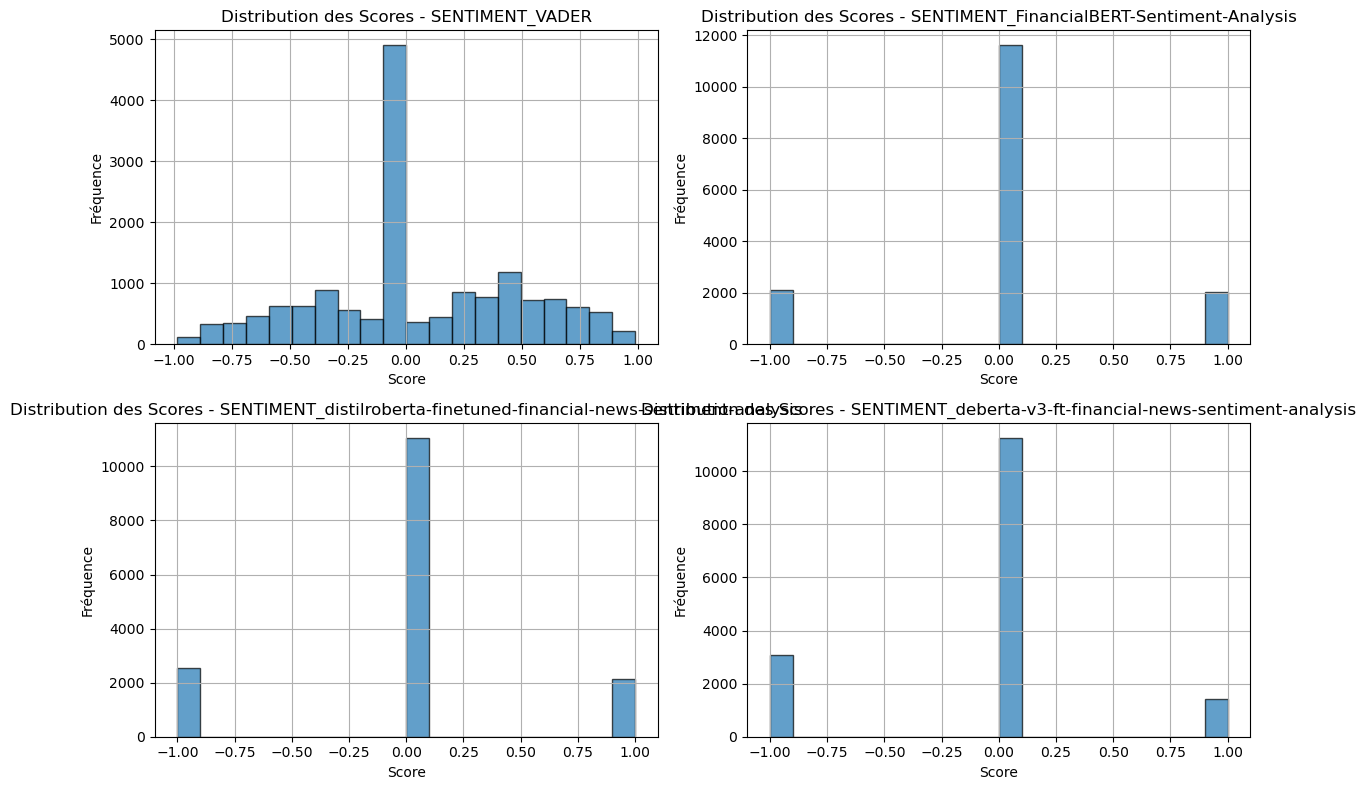

In [498]:
# ============================
# 2. Affichage des distributions de sentiments
# ============================

sentiment_cols = [
    'SENTIMENT_VADER',
    'SENTIMENT_FinancialBERT-Sentiment-Analysis',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, model in enumerate(sentiment_cols):
    axes[i].hist(df_annee_2022[model], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(f"Distribution des Scores - {model}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Fréquence")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


On observe que la plupart des modèles classent une grande majorité des tweets comme neutres (0), avec seulement quelques valeurs extrêmes à -1 (négatif) ou 1 (positif).

Cette répartition peut s'expliquer de deux manières :

- Les tweets sont réellement neutres, sans expressions marquées d’opinion positive ou négative.
- Les modèles interprètent de manière biaisée et attribuent des scores neutres par défaut, manquant ainsi de sensibilité aux nuances du langage.

On va supposer pour la suite du projet que les tweets sont réellement neutres.  
Car après relecture de certains tweets, on constate qu’une grande partie d’entre eux sont effectivement neutres, sans expression d’opinion ou de jugement. Ces tweets, n’ayant pas de charge émotionnelle ni d’intention marquée, sont considérés comme non influents sur le marché et seront donc exclus des analyses stratégiques dans la suite du projet.

In [499]:

# ============================
# 3. Agrégation quotidienne par vérification et fitrage à l'année 2022
# ============================
for sentiment_col in sentiment_cols:
    df_annee_2022 = df_annee_2022[df_annee_2022[sentiment_col].abs()>0.1]

df_verified = df_annee_2022[df_annee_2022['verified']]
df_non_verified = df_annee_2022[~df_annee_2022['verified']]

def daily_sentiment_avg_weighted(df, sentiment_cols, weight_verified=0.5, weight_non_verified=0.5):
    
    # Séparer les groupes
    df_verified = df[df['verified']]
    df_non_verified = df[~df['verified']]

    # Moyennes par groupe
    daily_verified = df_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()
    daily_non_verified = df_non_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()

    # Fusion des deux DataFrames sur index
    df_combined = pd.merge(daily_verified, daily_non_verified, 
                           left_index=True, right_index=True, 
                           suffixes=('_verified', '_non_verified'))

    # Calcul de la moyenne pondérée
    weighted_sentiments = {}
    for col in sentiment_cols:
        verified_col = f"{col}_verified"
        non_verified_col = f"{col}_non_verified"
        weighted_sentiments[col] = (
            weight_verified * df_combined[verified_col] +
            weight_non_verified * df_combined[non_verified_col]
        )

    # Construire le DataFrame final
    df_weighted = pd.DataFrame(weighted_sentiments)
    df_weighted.reset_index(inplace=True)
    df_weighted.rename(columns={'query_date': 'date'}, inplace=True)
    df_weighted['date'] = pd.to_datetime(df_weighted['date'])

    return df_weighted

df_daily = daily_sentiment_avg_weighted(df_annee_2022, sentiment_cols, weight_verified=0.25, weight_non_verified=0.75)
df_daily


,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis
0,2022-01-02,2022,1,0.292875,-1.000000,-1.000000,0.500000
1,2022-01-03,2022,1,0.538913,1.000000,1.000000,1.000000
2,2022-01-04,2022,1,-0.086175,0.200000,0.400000,0.400000
3,2022-01-05,2022,1,0.367800,1.000000,1.000000,1.000000
4,2022-01-06,2022,1,-0.169650,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
232,2022-12-26,2022,12,0.273500,-0.500000,-0.500000,-0.500000
233,2022-12-27,2022,12,-0.418033,-0.625000,-0.625000,-0.625000
234,2022-12-28,2022,12,-0.146321,-0.208333,-0.041667,-0.208333
235,2022-12-29,2022,12,0.286355,0.625000,0.625000,0.625000


In [500]:

# ============================
# 4. Données de marché (TSLA)
# ============================

df_market = yf.download("TSLA", start=str(annee)+"-01-01", end=str(annee+1)+"-01-01", interval="1d")

if isinstance(df_market.columns, pd.MultiIndex):
    df_market.columns = df_market.columns.get_level_values(0)

df_market["Daily_Change_%"] = df_market["Close"].pct_change() * 100
df_market = df_market[["Open", "High", "Low", "Close", "Volume", "Daily_Change_%"]]
df_market['date'] = pd.to_datetime(df_market.index)
df_market.reset_index(drop=True, inplace=True)
df_market.head()


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,Daily_Change_%,date
0,382.583344,400.356659,378.679993,399.926666,103931400,NaN,2022-01-03
1,396.516663,402.666656,374.350006,383.196655,100248300,-4.183270,2022-01-04
2,382.216675,390.113342,360.336670,362.706665,80119800,-5.347121,2022-01-05
3,359.000000,362.666656,340.166656,354.899994,90336600,-2.152337,2022-01-06
4,360.123322,360.309998,336.666656,342.320007,84164700,-3.544657,2022-01-07


In [501]:
# ============================
# 5. Fusion des données
# ============================

df_combined = pd.merge(df_daily, df_market, on="date", how="inner")

# Moyenne glissante 7 jours
rolling_cols = df_combined.select_dtypes(include='number').columns

rolling_cols = rolling_cols[~rolling_cols.isin(['year', 'month', 'date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Change_%'])]
df_rolling_verified_combined = df_combined.copy()
df_rolling_verified_combined[rolling_cols] = df_combined[rolling_cols].rolling(window=1).mean()
df_rolling_verified_combined.head()

,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis,Open,High,Low,Close,Volume,Daily_Change_%
0,2022-01-03,2022,1,0.538913,1.00,1.00,1.00,382.583344,400.356659,378.679993,399.926666,103931400,NaN
1,2022-01-04,2022,1,-0.086175,0.20,0.40,0.40,396.516663,402.666656,374.350006,383.196655,100248300,-4.183270
2,2022-01-05,2022,1,0.367800,1.00,1.00,1.00,382.216675,390.113342,360.336670,362.706665,80119800,-5.347121
3,2022-01-06,2022,1,-0.169650,0.00,0.00,0.00,359.000000,362.666656,340.166656,354.899994,90336600,-2.152337
4,2022-01-07,2022,1,0.098525,0.25,0.25,0.25,360.123322,360.309998,336.666656,342.320007,84164700,-3.544657


In [502]:

# ============================
# 6. Normalisation
# ============================

# Normalisation de la variation journalière
max_abs_change = df_rolling_verified_combined["Daily_Change_%"].abs().max()
df_rolling_verified_combined["Daily_Change_%_normalized"] = df_rolling_verified_combined["Daily_Change_%"] / max_abs_change
mean_close = df_rolling_verified_combined["Close"].mean()
std_close = df_rolling_verified_combined["Close"].std()
df_rolling_verified_combined["Close_normalized"] = (df_rolling_verified_combined["Close"]-mean_close) / std_close
max_abs_open = df_rolling_verified_combined["Open"].abs().max()
df_rolling_verified_combined["Open_normalized"] = df_rolling_verified_combined["Open"] / max_abs_open

# Normalisation des scores de sentiment
for col in sentiment_cols:
    max_abs_sent = df_rolling_verified_combined[col].abs().max()
    df_rolling_verified_combined[col + "_normalized"] = (df_rolling_verified_combined[col])/max_abs_sent

df_rolling_verified_combined.head()

,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis,Open,High,Low,Close,Volume,Daily_Change_%,Daily_Change_%_normalized,Close_normalized,Open_normalized,SENTIMENT_VADER_normalized,SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_normalized
0,2022-01-03,2022,1,0.538913,1.00,1.00,1.00,382.583344,400.356659,378.679993,399.926666,103931400,NaN,NaN,2.188295,0.964861,0.667922,1.00,1.00,1.00
1,2022-01-04,2022,1,-0.086175,0.20,0.40,0.40,396.516663,402.666656,374.350006,383.196655,100248300,-4.183270,-0.343338,1.923208,1.000000,-0.106804,0.20,0.40,0.40
2,2022-01-05,2022,1,0.367800,1.00,1.00,1.00,382.216675,390.113342,360.336670,362.706665,80119800,-5.347121,-0.438860,1.598543,0.963936,0.455847,1.00,1.00,1.00
3,2022-01-06,2022,1,-0.169650,0.00,0.00,0.00,359.000000,362.666656,340.166656,354.899994,90336600,-2.152337,-0.176651,1.474847,0.905384,-0.210262,0.00,0.00,0.00
4,2022-01-07,2022,1,0.098525,0.25,0.25,0.25,360.123322,360.309998,336.666656,342.320007,84164700,-3.544657,-0.290924,1.275516,0.908217,0.122111,0.25,0.25,0.25


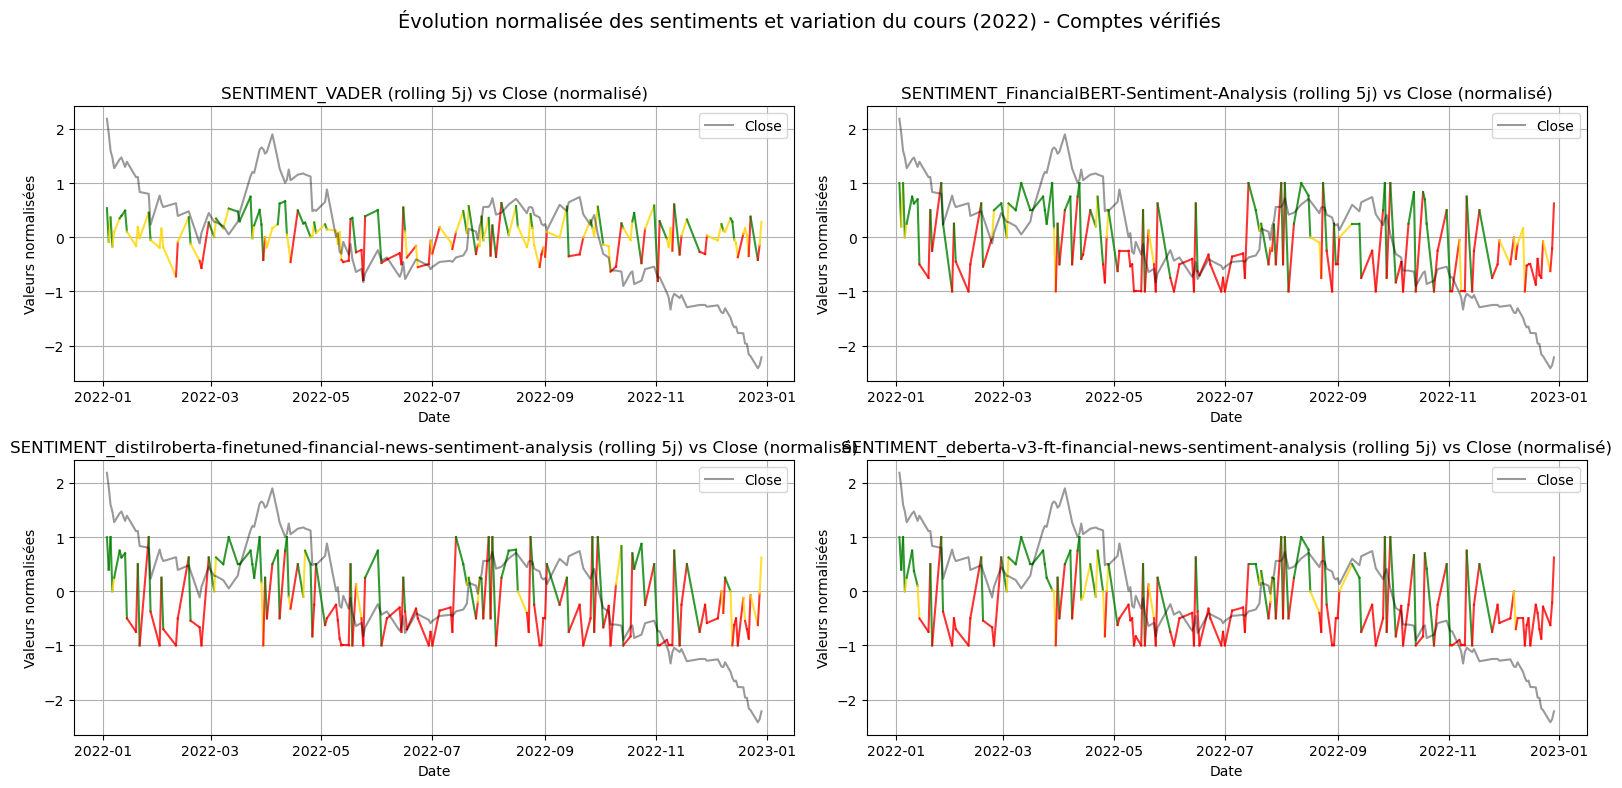

In [503]:
# ============================
# 7. Visualisation avec couleurs conditionnelles
# ============================

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(sentiment_cols):
    sentiment_norm = col + "_normalized"

    x = df_rolling_verified_combined['date']
    y = df_rolling_verified_combined[col]

    # Initialiser la première valeur
    prev_x, prev_y = x.iloc[0], y.iloc[0]
    
    # Tracer la courbe avec changement de couleur selon la valeur
    for j in range(1, len(x)):
        curr_x, curr_y = x.iloc[j], y.iloc[j]

        # Déterminer la couleur en fonction de la valeur précédente
        if prev_y > 0.2:
            color = 'green'
        elif prev_y < -0.2:
            color = 'red'
        else:
            color = 'gold'  # jaune

        axes[i].plot([prev_x, curr_x], [prev_y, curr_y], color=color, alpha=0.8)

        prev_x, prev_y = curr_x, curr_y

    # Ajouter la courbe du prix
    axes[i].plot(df_rolling_verified_combined['date'], df_rolling_verified_combined['Close_normalized'], label='Close', color='black', alpha=0.4)

    axes[i].set_title(f"{col} (rolling 5j) vs Close (normalisé)")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Valeurs normalisées")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Évolution normalisée des sentiments et variation du cours (2022) - Comptes vérifiés", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [504]:


# ============================
# 7. Stratégie d'achat/vente
# ============================

# Fonction de simulation de stratégie d'achat/vente
def simulate_trading(df, sentiment_col, rolling_window=5, weight_verified=0.5, initial_cash=10000, buy_threshold=0.2, sell_threshold=-0.2):
    """
    Simule une stratégie simple d'achat/vente basée sur le score de sentiment pondéré.
    
    Args:
        df (pd.DataFrame): DataFrame combiné contenant les scores de sentiment et les cours boursiers.
        sentiment_col (str): Colonne de sentiment à utiliser (non lissée).
        rolling_window (int): Fenêtre pour la moyenne mobile sur le sentiment.
        weight_verified (float): Poids pour les comptes vérifiés (utilisé avant appel si recalcul des moyennes).
        initial_cash (float): Somme de départ.
        buy_threshold (float): Seuil de sentiment pour déclencher un achat.
        sell_threshold (float): Seuil de sentiment pour déclencher une vente.

    Returns:
        float: Pourcentage de gain ou de perte.
    """
    df = df.copy()

    # Lissage du sentiment
    df['sentiment_smooth'] = df[sentiment_col].rolling(window=rolling_window, min_periods=1).mean()

    position = 0  # Nombre d'actions détenues
    cash = initial_cash  # Capital disponible
    last_buy_price = 0

    for idx, row in df.iterrows():
        sentiment = row['sentiment_smooth']
        price = row['Open']  # Achat/vente à l'ouverture du jour

        # Signal d'achat
        if sentiment > buy_threshold and position == 0:
            position = cash / price
            cash = 0
            last_buy_price = price

        # Signal de vente
        elif sentiment < sell_threshold and position > 0:
            cash = position * price
            position = 0

    # Valeur finale du portefeuille
    final_value = cash + position * df.iloc[-1]['Close']
    percent_return = (final_value - initial_cash) / initial_cash * 100

    return percent_return


result = simulate_trading(
    df=df_rolling_verified_combined,
    sentiment_col='SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized',
    rolling_window=2,
    weight_verified=0.25,
    initial_cash=10000
)
print(f"Résultat de la simulation : {result:.2f}%")


Résultat de la simulation : 1.71%


### Interprétation du résultat initial

Ce résultat montre que cette stratégie arrive à capter un **petit signal exploitable à partir du sentiment Twitter**.

Ce n’est pas énorme (je termine à **10 171 $**), mais c’est **positif**, ce qui est encourageant sachant que :

- j'ai utilisé un **modèle extrêmement simple**,
- les **paramètres n'ont pas été optimisés**,
- et que **le cours de l’action cette année a globalement baissé**, ce qui rend la détection des hausses encore plus délicate.

---

### Étape suivante

Nous allons donc maintenant **optimiser les paramètres** pour cette année, afin d'observer :

- le **meilleur rendement possible** qu'on peut obtenir avec cette stratégie,
- et **quels paramètres** (modèle, seuils, lissage) permettent d’y parvenir.

In [505]:
best_result = -np.inf
best_params = {}

for sentiment_col in [
    'SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_normalized',
    'SENTIMENT_VADER_normalized'
]:
    for rolling in range(1, 8):
        for buy_t in np.arange(0, 1, 0.1):
            for sell_t in np.arange(-1, 0, 0.1):
                result = simulate_trading(
                    df=df_rolling_verified_combined,
                    sentiment_col=sentiment_col,
                    rolling_window=rolling,
                    buy_threshold=buy_t,
                    sell_threshold=sell_t,
                    initial_cash=10000
                )
                if result > best_result:
                    best_result = result
                    best_params = {
                        'model': sentiment_col,
                        'rolling': rolling,
                        'buy_threshold': buy_t,
                        'sell_threshold': sell_t,
                        'return': result
                    }

print("🏆 Meilleure configuration trouvée :")
print(best_params)


🏆 Meilleure configuration trouvée :
{'model': 'SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized', 'rolling': 1, 'buy_threshold': 0.30000000000000004, 'sell_threshold': -0.5000000000000001, 'return': 75.8598692532027}


### Résultat de l'optimisation

L’optimisation automatique a permis de tester **plusieurs modèles de sentiment**, **différentes fenêtres de lissage**, ainsi que **des seuils d’achat/vente** variés.

La **meilleure configuration trouvée** est la suivante :

- **Modèle** : `SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized`
- **Fenêtre de lissage** (`rolling`) : `1` (pas de lissage)
- **Seuil d'achat** (`buy_threshold`) : `0.3`
- **Seuil de vente** (`sell_threshold`) : `-0.5`
- **Rendement obtenu** : **+75.86%**

---

### Interprétation

Cette configuration permet d’obtenir un **rendement impressionnant de +75.86%**, uniquement en se basant sur le **sentiment Twitter** et en utilisant un modèle NLP spécialisé dans le domaine financier.

Cela suggère que :

- Le modèle **FinancialBERT** est particulièrement efficace sur cette année,
- Une stratégie avec **réaction immédiate** (rolling = 1) semble ici mieux fonctionner qu’un lissage,
- Le seuil d'achat de `0.3` (en valeur absolue) est **plus bas que le seuil de vente de `-0.5`**, ce qui signifie que la stratégie est **plus facilement déclenchée à l'achat** qu’à la vente.
- Autrement dit, il suffit d’un **optimisme modéré** pour acheter, alors qu’il faut un **pessimisme plus marqué** pour vendre selon le modèle **FinancialBERT**.
- Le marché de 2023, bien que baissier, a présenté des **opportunités exploitables par les signaux de sentiment**.

---

### Conclusion

Cette simulation montre qu’un modèle de sentiment **bien calibré** peut offrir des signaux pertinents pour une stratégie d’investissement, même sans indicateurs techniques classiques.  
C’est une preuve de concept intéressante pour intégrer les **données sociales** dans la prise de décision boursière.
